# Setup

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [52]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from torch.autograd import Variable
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prophet  import Prophet

In [54]:
data = pd.read_csv('/content/drive/MyDrive/Kaggle/TSLA.csv')

# EDA & Preprocessing

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [56]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [57]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [58]:
data.drop('Adj Close',axis=1,inplace=True)

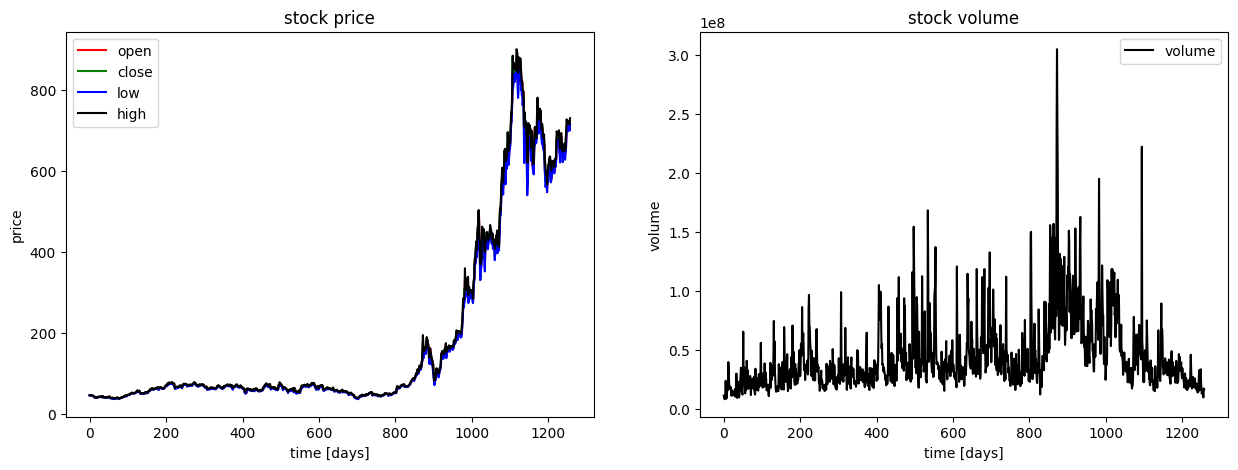

In [59]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(data.Open.values, color='red', label='open')
plt.plot(data.Close.values, color='green', label='close')
plt.plot(data.Low.values, color='blue', label='low')
plt.plot(data.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(data.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [60]:
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Open,High,Low,Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,10327500
...,...,...,...,...,...,...
1253,2021-08-09,710.169983,719.030029,705.130005,713.760010,14715300
1254,2021-08-10,713.989990,716.590027,701.880005,709.989990,13432300
1255,2021-08-11,712.710022,715.179993,704.210022,707.820007,9800600
1256,2021-08-12,706.340027,722.799988,699.400024,722.250000,17459100


In [61]:
# Extract the 'Close' prices as the target variable
Close = data[['Close']]

In [62]:
train = Close.values
train.shape

(1258, 1)

In [63]:
def sliding_windows(data, seq_l):
  x = []
  y = []
  n = len(data)

  for i in range(n - seq_l -1):
    start_x = i
    end_x = i+ seq_l
    x_i = data[start_x : end_x]
    y_i = data[end_x]

    x.append(x_i)
    y.append(y_i)

  return np.array(x), np.array(y)


In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))
training_data = scaler.fit_transform(train)

In [65]:
seq_length = 30
x, y = sliding_windows(training_data, seq_length)

In [66]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [67]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # init hidden state
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # init cell state
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

# Model 1

In [68]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

In [69]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [70]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [71]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.02364284358918667
Epoch: 10, 0.004618389066308737
Epoch: 20, 0.0033097853884100914
Epoch: 30, 0.002117946743965149
Epoch: 40, 0.000757912639528513
Epoch: 50, 0.000218900284380652
Epoch: 60, 0.00011043837002944201
Epoch: 70, 7.29379607946612e-05
Epoch: 80, 5.9245310694677755e-05
Epoch: 90, 5.466549191623926e-05


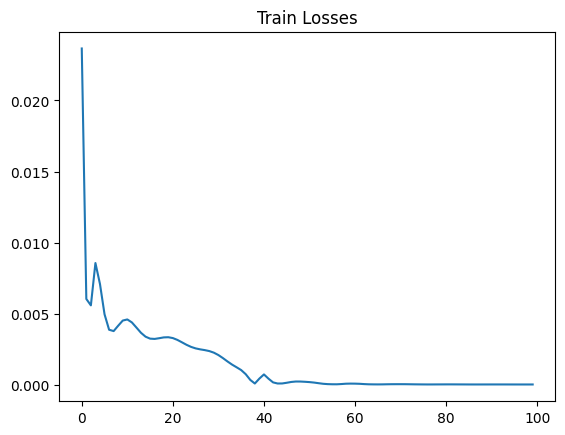

In [72]:
plt.title("Train Losses")
plt.plot(train_losses)
plt.show()

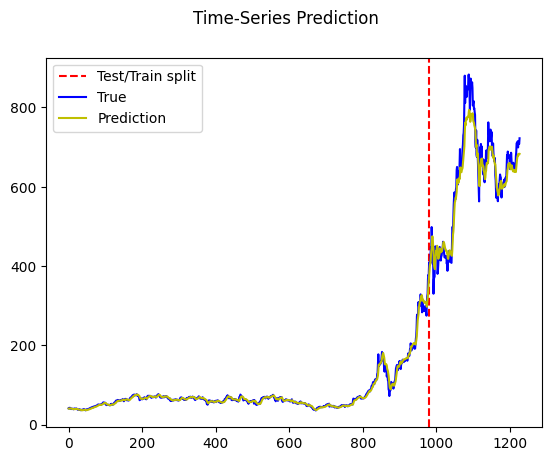

In [73]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [74]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))

LSTM: Test data MSE:  1447.8299076115763
LSTM: Test data MAE:  28.92500984272819
LSTM: Test data r2_score:  0.9209387347436364


# Model 2

In [75]:
num_epochs = 50
learning_rate = 0.01

input_size = 1
hidden_size = 16
num_layers = 1

num_classes = 1

In [76]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [77]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [78]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.04352659359574318
Epoch: 10, 0.003944806754589081
Epoch: 20, 0.0028293647337704897
Epoch: 30, 0.0022843549959361553
Epoch: 40, 0.0016620465321466327


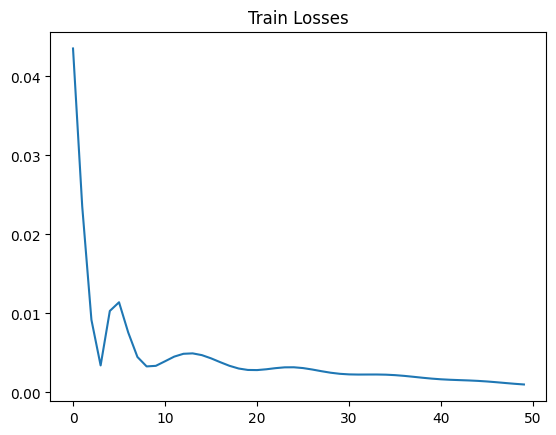

In [79]:
plt.title("Train Losses")
plt.plot(train_losses)
plt.show()

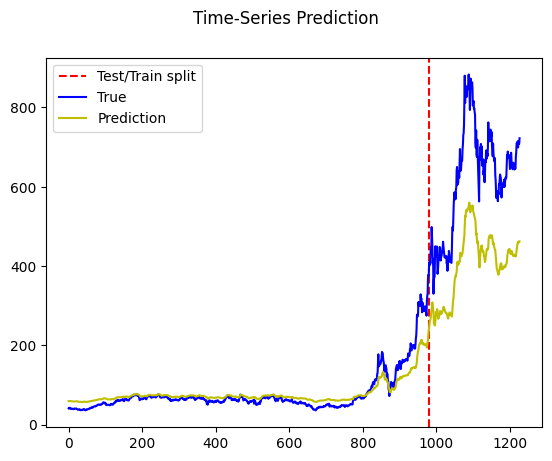

In [80]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [81]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))

LSTM: Test data MSE:  49245.08986955319
LSTM: Test data MAE:  215.07926621807232
LSTM: Test data r2_score:  -1.689113612228767


# Model 3


In [82]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 64
num_layers = 1

num_classes = 1

In [83]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [84]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.03126915916800499
Epoch: 10, 0.0035751787945628166
Epoch: 20, 0.002642910461872816
Epoch: 30, 0.0014668653020635247
Epoch: 40, 0.00018345339049119502
Epoch: 50, 5.877611692994833e-05
Epoch: 60, 5.088343459647149e-05
Epoch: 70, 5.048329694545828e-05
Epoch: 80, 4.752907989313826e-05
Epoch: 90, 4.616516889655031e-05


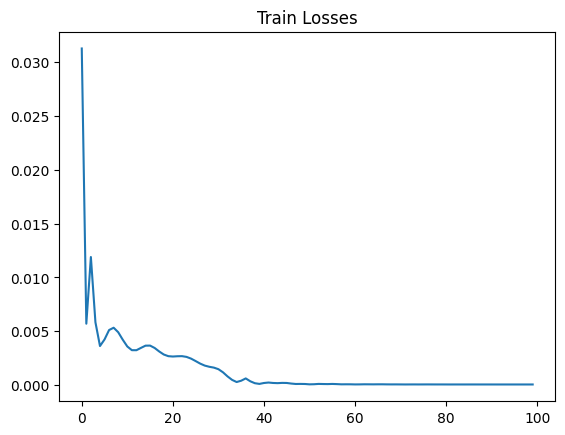

In [86]:
plt.title("Train Losses")
plt.plot(train_losses)
plt.show()

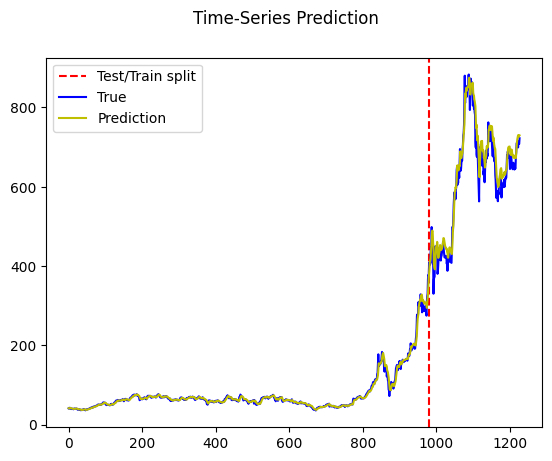

In [87]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [88]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))

LSTM: Test data MSE:  1042.7550686083655
LSTM: Test data MAE:  25.479450478501754
LSTM: Test data r2_score:  0.9430585494585728


# Model 4


In [89]:
num_epochs = 80
learning_rate = 0.01

input_size = 1
hidden_size = 128
num_layers = 1

num_classes = 1

In [90]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [91]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [92]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.004330952186137438
Epoch: 10, 0.003828149288892746
Epoch: 20, 0.0028373212553560734
Epoch: 30, 0.0034457107540220022
Epoch: 40, 0.0029545463621616364
Epoch: 50, 0.002019105479121208
Epoch: 60, 0.0007410276448354125
Epoch: 70, 0.00017369499255437404


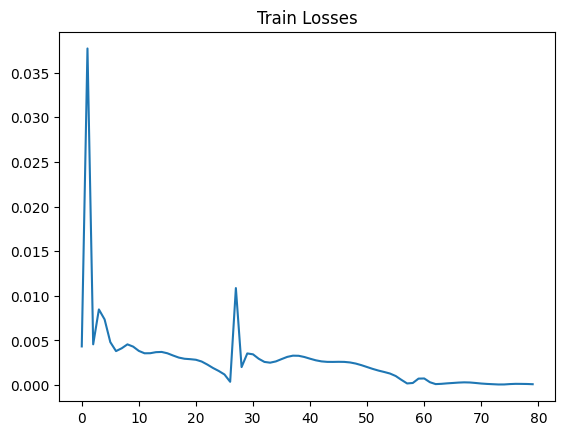

In [93]:
plt.title("Train Losses")
plt.plot(train_losses)
plt.show()

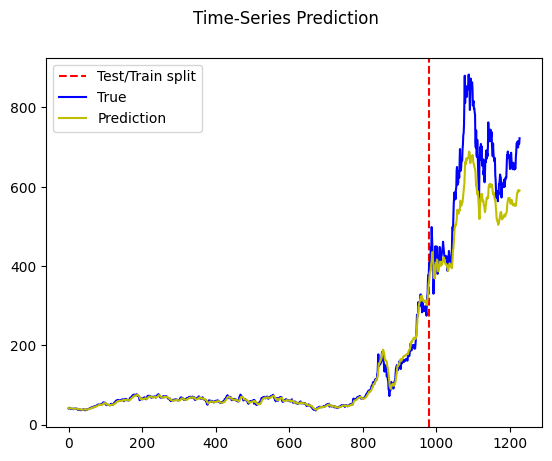

In [94]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [95]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))

LSTM: Test data MSE:  10569.488014556477
LSTM: Test data MAE:  89.61976078271742
LSTM: Test data r2_score:  0.42283476038886325


# Model 5


In [96]:
seq_length = 180
x, y = sliding_windows(training_data, seq_length)

In [97]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [98]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 64
num_layers = 1

num_classes = 1

In [99]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [100]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.0567534975707531
Epoch: 10, 0.007443989161401987
Epoch: 20, 0.003995127510279417
Epoch: 30, 0.0003157838073093444
Epoch: 40, 0.00041328539373353124
Epoch: 50, 0.00013975381443742663
Epoch: 60, 0.00015184732910711318
Epoch: 70, 0.00012124265776947141
Epoch: 80, 0.00011221414752071723
Epoch: 90, 0.00011061866825912148


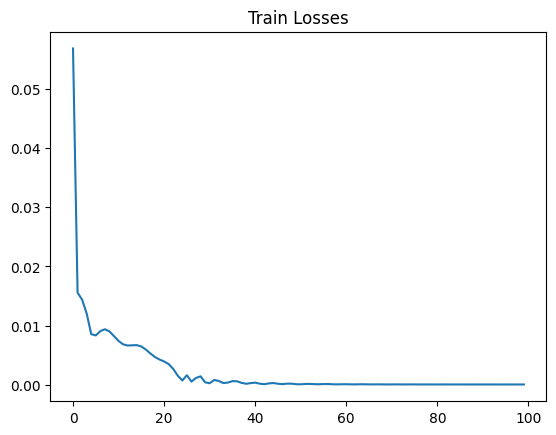

In [102]:
plt.title("Train Losses")
plt.plot(train_losses)
plt.show()

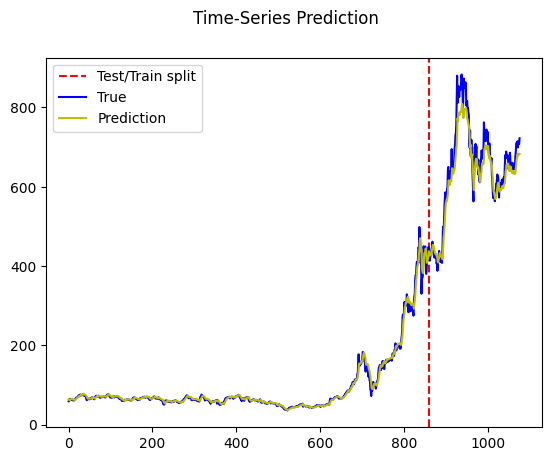

In [103]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [104]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))

LSTM: Test data MSE:  1336.0338693735187
LSTM: Test data MAE:  28.440979150598043
LSTM: Test data r2_score:  0.9081552912904063


# Model 6


In [105]:
seq_length = 90
x, y = sliding_windows(training_data, seq_length)

In [106]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [107]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

In [108]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [109]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [110]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.009186030365526676
Epoch: 10, 0.005102428607642651
Epoch: 20, 0.0012265352997928858
Epoch: 30, 0.0005727338138967752
Epoch: 40, 0.00020973006030544639
Epoch: 50, 0.00013064194354228675
Epoch: 60, 0.00010051848948933184
Epoch: 70, 9.351839253213257e-05
Epoch: 80, 9.010673966258764e-05
Epoch: 90, 8.865349809639156e-05


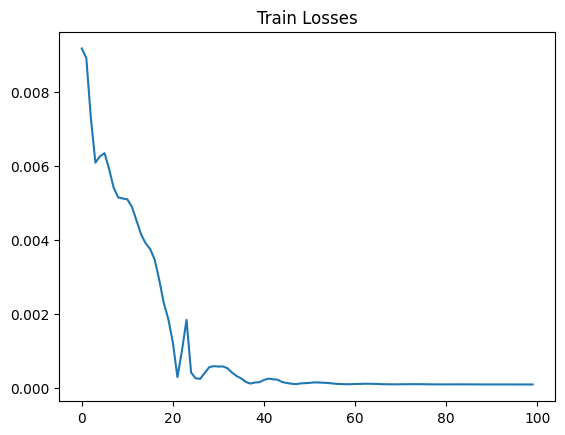

In [111]:
plt.title("Train Losses")
plt.plot(train_losses)
plt.show()

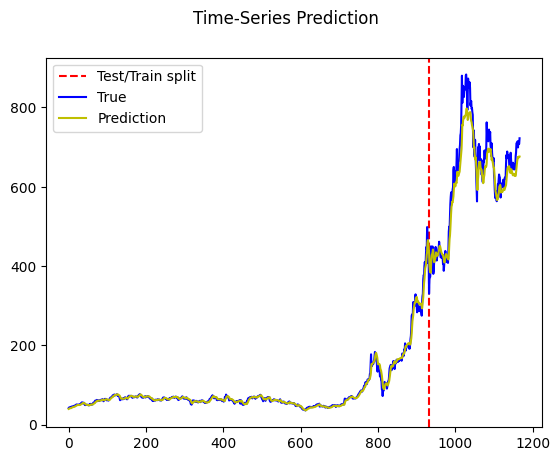

In [112]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [113]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("LSTM: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("LSTM: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("LSTM: Test data r2_score: ", r2_score(original_ytest,test_predict))

LSTM: Test data MSE:  1645.8665442149136
LSTM: Test data MAE:  32.01695679618922
LSTM: Test data r2_score:  0.9043808928831417


# GRU Method

In [114]:
seq_length = 30
x, y = sliding_windows(training_data, seq_length)

In [115]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [116]:
class GRU(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size


        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))


        ula, h_out = self.gru(x, h_0)

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

In [117]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 32
num_layers = 1

num_classes = 1

In [118]:
model = GRU(num_classes, input_size, hidden_size, num_layers)

In [119]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [120]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.01095767505466938
Epoch: 10, 0.0025277258828282356
Epoch: 20, 0.001119535882025957
Epoch: 30, 3.683322938741185e-05
Epoch: 40, 8.33271406008862e-05
Epoch: 50, 6.463437603088096e-05
Epoch: 60, 3.985308649134822e-05
Epoch: 70, 3.405462484806776e-05
Epoch: 80, 3.213624586351216e-05
Epoch: 90, 3.0663901270600036e-05


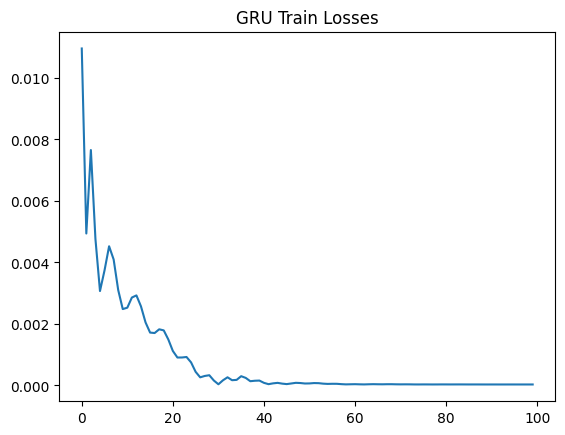

In [121]:
plt.title("GRU Train Losses")
plt.plot(train_losses)
plt.show()

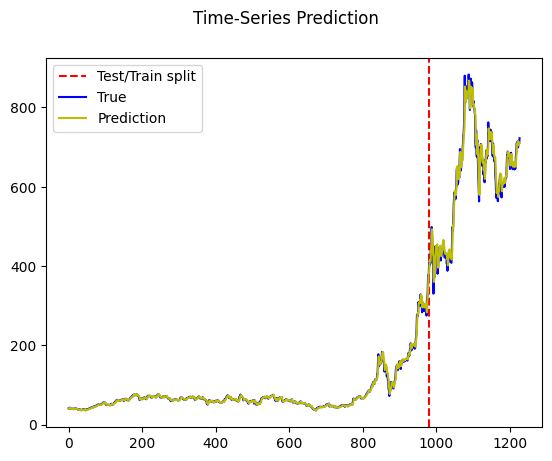

In [122]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [123]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("GRU: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("GRU: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("GRU: Test data r2_score: ", r2_score(original_ytest,test_predict))

GRU: Test data MSE:  577.4175860681631
GRU: Test data MAE:  17.838732676248725
GRU: Test data r2_score:  0.9684691104280797


# GRU Model 2

In [124]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 64
num_layers = 1

num_classes = 1

In [125]:
model = GRU(num_classes, input_size, hidden_size, num_layers)

In [126]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [127]:
train_losses = []
model.train()

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, {loss.item()}")

Epoch: 0, 0.005857149604707956
Epoch: 10, 0.006273649167269468
Epoch: 20, 0.003189501818269491
Epoch: 30, 0.0016343495808541775
Epoch: 40, 0.00032830878626555204
Epoch: 50, 0.00016329879872500896
Epoch: 60, 3.926674253307283e-05
Epoch: 70, 4.3746349547291175e-05
Epoch: 80, 3.1903797207633033e-05
Epoch: 90, 3.0829207389615476e-05


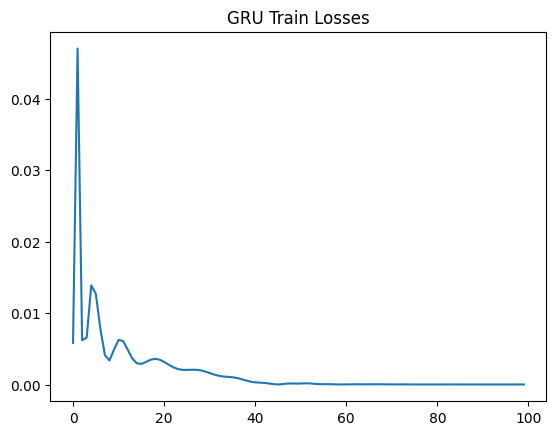

In [128]:
plt.title("GRU Train Losses")
plt.plot(train_losses)
plt.show()

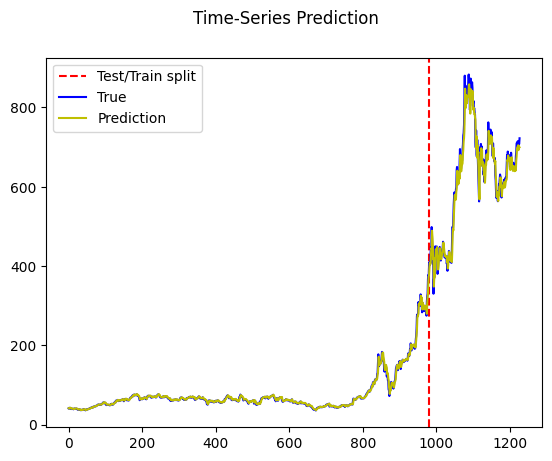

In [129]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot, color='b')
plt.plot(data_predict, color='y')
plt.legend(["Test/Train split", "True", "Prediction"], loc ="upper left")

plt.suptitle('Time-Series Prediction')
plt.show()

In [130]:
test_predict = model(testX)
test_predict = test_predict.detach().numpy()
test_predict = scaler.inverse_transform(test_predict)
original_ytest = scaler.inverse_transform(testY.reshape(-1,1))

print("GRU: Test data MSE: ",mean_squared_error(original_ytest,test_predict))
print("GRU: Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("GRU: Test data r2_score: ", r2_score(original_ytest,test_predict))

GRU: Test data MSE:  623.3660430390303
GRU: Test data MAE:  18.573615264323127
GRU: Test data r2_score:  0.9659600151775974


# Multivariate

In [131]:
data = pd.read_csv('/content/drive/MyDrive/Kaggle/TSLA.csv')
data = data[['Open', 'Close']]

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   Close   1258 non-null   float64
dtypes: float64(2)
memory usage: 19.8 KB


In [133]:
def load_data(df, seq_len, out_feature=2, train_ratio=0.8, is_test=False):
    scaler = StandardScaler()
    scaler.fit(df)

    train_norm = scaler.transform(df)
    data = []
    for index in range(len(train_norm) - seq_len):
        # create all possible sequences
        data.append(train_norm[index:index + seq_len])

    data = np.array(data)

    train_len = len(data) if is_test else int(train_ratio * len(data))

    # train_x are sequences of seq_len-1 days. Features of each day are OPEN, CLOSE, HIGH, LOW, VOLUME
    # train_y is CLOSE price of day seq_len
    # shape is (n_data, n_sequence, features)
    train_x = data[:train_len, :-1, :]
    train_y = data[:train_len, -1, -out_feature:]

    val_x = data[train_len:, :-1, :]
    val_y = data[train_len:, -1, -out_feature:]

    return train_x, train_y, val_x, val_y

In [134]:
seq_len = 30
batch_size = 128
n_epoch = 50
n_feature = 2
out_feature = 1

train = data.loc[:'2019']
test = data.loc['2020':]

train_x, train_y, val_x, val_y = load_data(data, seq_len, out_feature=out_feature)

In [135]:
train_x = torch.from_numpy(train_x).float().cuda()
train_y = torch.from_numpy(train_y).float().cuda()
val_x = torch.from_numpy(val_x).float().cuda()
val_y = torch.from_numpy(val_y).float().cuda()

train = torch.utils.data.TensorDataset(train_x, train_y)
val = torch.utils.data.TensorDataset(val_x, val_y)

train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=batch_size,
                                               shuffle=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val,
                                             batch_size=1,
                                             shuffle=False)

In [136]:
class MultiRNN(nn.Module):

    def __init__(self, n_feature=5, out_feature=5, n_hidden=512, n_layers=2, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature

        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers, dropout=self.drop_prob, batch_first=True)

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(n_hidden, out_feature)


    def forward(self, x, hidden):
        # x.shape (batch, seq_len, n_features)
        l_out, l_hidden = self.lstm(x, hidden)

        # out.shape (batch, seq_len, n_hidden*direction)
        out = self.dropout(l_out)

        # out.shape (batch, out_feature)
        out = self.fc(out[:, -1, :])

        # return the final output and the hidden state
        return out, l_hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data


        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        return hidden


In [137]:
net = MultiRNN(n_feature=n_feature, out_feature=out_feature)
net.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
val_loss_list = []

End of Epoch  0 Val loss:  4.068397016786948
End of Epoch  1 Val loss:  3.155109149774885
End of Epoch  2 Val loss:  1.0052736205298727
End of Epoch  3 Val loss:  3.6289776243814607
End of Epoch  4 Val loss:  1.6523951186639507
End of Epoch  5 Val loss:  1.8318861873472125
End of Epoch  6 Val loss:  1.3402625333396643
End of Epoch  7 Val loss:  0.6201151056832426
End of Epoch  8 Val loss:  0.24729420469651892
End of Epoch  9 Val loss:  0.5080197026836094
End of Epoch  10 Val loss:  0.5115986659258807
End of Epoch  11 Val loss:  0.27778237512320925
End of Epoch  12 Val loss:  0.13537599799069014
End of Epoch  13 Val loss:  0.15847295230783429
End of Epoch  14 Val loss:  0.1474731189590973
End of Epoch  15 Val loss:  0.09011914304731518
End of Epoch  16 Val loss:  0.09413939969222267
End of Epoch  17 Val loss:  0.09726109565045273
End of Epoch  18 Val loss:  0.0607350186070494
End of Epoch  19 Val loss:  0.05220599000686266
End of Epoch  20 Val loss:  0.059933777336092495
End of Epoch  2

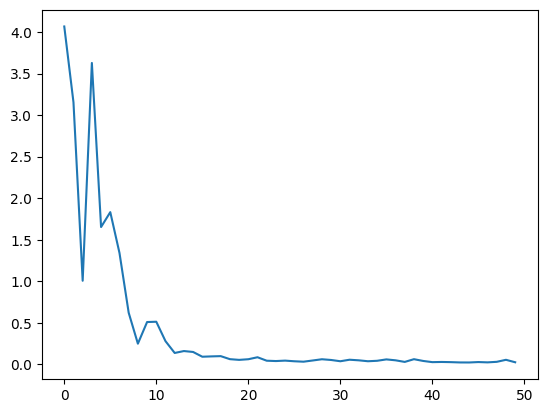

In [138]:
for epoch in range(n_epoch):

    for i, (x, y) in enumerate(train_loader):
        output, hidden = net(x, net.init_hidden(batch_size))
        loss = criterion(output, y)

        net.zero_grad()
        loss.backward()
        optimizer.step()

    net.eval()
    val_loss_sum = 0
    for i, (x, y) in enumerate(val_loader):
        with torch.no_grad():
            output, hidden = net(x, net.init_hidden(1))
            val_loss = criterion(output, y)
            val_loss_sum += val_loss.item()


    val_loss_list.append(val_loss_sum/len(val_loader))
    print('End of Epoch ', epoch, 'Val loss: ', val_loss_sum/len(val_loader))
    net.train()

plt.plot(val_loss_list)

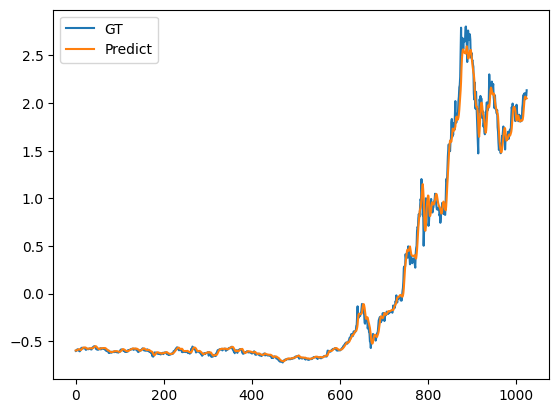

In [139]:
# test_df.shape
test_x, test_y, _, _ = load_data(test, seq_len, out_feature=out_feature, is_test=True)

test_x = torch.from_numpy(test_x).float().cuda()
test_y = torch.from_numpy(test_y).float().cuda()

test = torch.utils.data.TensorDataset(test_x, test_y)

test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=1, shuffle=False)

net.eval()
test_predict = []
for i, (x, y) in enumerate(test_loader):

    with torch.no_grad():
        output, hidden = net(x, net.init_hidden(1))
    test_predict.append(output[:, -1])
    test_predict_tensor = torch.cat(test_predict, dim=0)

plt.plot(test_y[:, -1].cpu().numpy(), label='GT')
plt.plot(test_predict_tensor.cpu().numpy(), label='Predict')
plt.legend()

In [140]:
# Calculate evaluation metrics
test_y = test_y.cpu().numpy()
test_predict_tensor = test_predict_tensor.cpu().numpy()

mse = mean_squared_error(test_y, test_predict_tensor)
mae = mean_absolute_error(test_y, test_predict_tensor)
r2 = r2_score(test_y, test_predict_tensor)

print('MSE:', mse)
print('MAE:', mae)
print('R2 Score:', r2)

MSE: 0.00522194
MAE: 0.037641324
R2 Score: 0.9948566058354613


# ARIMA

In [141]:
data = pd.read_csv('/content/drive/MyDrive/Kaggle/TSLA.csv')

In [142]:
data.drop('Adj Close',axis=1,inplace=True)

In [143]:
data['Date'] = pd.to_datetime(data['Date'])

In [144]:
# Extract the 'Close' prices as the target variable
Close = data[['Close']]

In [145]:
train = Close.values

In [146]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming you have the 'train' variable containing the time series data

# Split the data into train and test sets
train_size = int(len(train) * 0.8)
train_data = train[:train_size]
test_data = train[train_size:]

# Train the ARIMA model
model = ARIMA(train_data, order=(3, 0, 1))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=train_size, end=len(train)-1)

# Calculate evaluation metrics
test_target = test_data.flatten()
mse = mean_squared_error(test_target, predictions)
mae = mean_absolute_error(test_target, predictions)
r2 = r2_score(test_target, predictions)

# Print the evaluation metrics
print("ARIMA: Test data MSE:", mse)
print("ARIMA: Test data MAE:", mae)
print("ARIMA: Test data R2 score:", r2)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA: Test data MSE: 110024.8051003639
ARIMA: Test data MAE: 299.6721127368787
ARIMA: Test data R2 score: -4.756640700353217


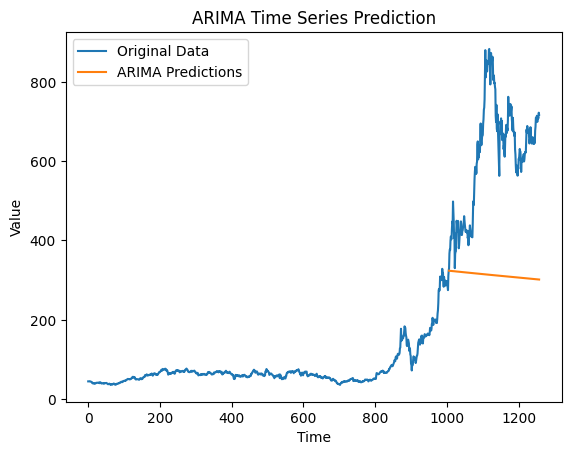

In [147]:
# Plot the original data and predictions
plt.plot(train, label='Original Data')
plt.plot(range(train_size, len(train)), predictions, label='ARIMA Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Time Series Prediction')
plt.legend()
plt.show()

# Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn3z3en02/7uvbifuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn3z3en02/zj1btxvm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12524', 'data', 'file=/tmp/tmpn3z3en02/7uvbifuk.json', 'init=/tmp/tmpn3z3en02/zj1btxvm.json', 'output', 'file=/tmp/tmpn3z3en02/prophet_modelmu5myvet/prophet_model-20230620091744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:17:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet: Test data MSE: 82985.73268603215
Prophet: Test data MAE: 263.43136574833994
Prophet: Test data R2 score: -3.3419213139552735


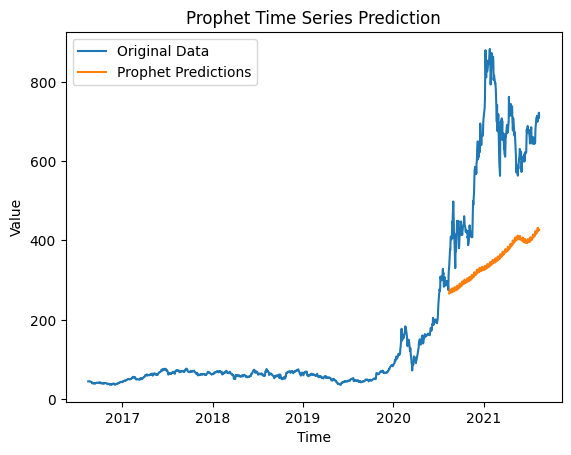

In [148]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming you have the 'train' variable containing the time series data

# Prepare the data for Prophet
data = pd.DataFrame({'ds': pd.to_datetime(data['Date']), 'y': train.flatten()})

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Train the Prophet model
model = Prophet()
model.fit(train_data)

# Make predictions on the test set
future = model.make_future_dataframe(periods=len(test_data))
prophet_predictions = model.predict(future)['yhat'][train_size:]

# Calculate evaluation metrics
test_target = test_data['y'].values
mse = mean_squared_error(test_target, prophet_predictions)
mae = mean_absolute_error(test_target, prophet_predictions)
r2 = r2_score(test_target, prophet_predictions)

# Print the evaluation metrics
print("Prophet: Test data MSE:", mse)
print("Prophet: Test data MAE:", mae)
print("Prophet: Test data R2 score:", r2)

# Plot the original data and predictions
plt.plot(data['ds'], data['y'], label='Original Data')
plt.plot(test_data['ds'], prophet_predictions, label='Prophet Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Prophet Time Series Prediction')
plt.legend()
plt.show()
